In [98]:
import mne # package for reading edf data
import numpy as np
import pandas as pd

import json
import matplotlib.pyplot as plt

Description for reference: This dataset accompanies the publication by Daly et al. (2018) and has been analysed in Daly et al. (2014; 2015a; 2015b) (please see Section 5 for full references). The purpose of the research activity in which the data were collected was to investigate the EEG neural correlates of music-induced emotion. For this purpose 31 healthy adult participants listened to 40 music clips of 12 s duration each, targeting a range of emotional states. The music clips comprised excerpts from film scores spanning a range of styles and rated on induced emotion.
The dataset contains unprocessed EEG data from all 31 participants (age range 18-66, 18 female) while listening to the music clips, together with the reported induced emotional responses . The paradigm involved 6 runs of EEG recordings. The first and last runs were resting state runs, during which participants were instructed to sit still and rest for 300 s. The other 4 runs each contained 10 music listening trials.

In [99]:
def get_recording(subjectnum, trialnum):
    '''retrieves trial eeg recording given a subject number and trial number'''
    subjectnum = '0' + (str(subjectnum)) if subjectnum < 10 else str(subjectnum)
    file = r"sub-"+str(subjectnum)+r"\eeg\sub-"+str(subjectnum)+r"_task-run"+str(trialnum)+r"_eeg.edf"
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    # you can get the metadata included in the file and a list of all channels:
    # info = data.info
    # channels = data.ch_names
    recording = data.to_data_frame().infer_objects()
    return recording
subject1 = get_recording(1,2)
subject1.head()

Extracting EDF parameters from c:\Users\Staro\Desktop\UCSD\WI2021\cogs189\project\sub-01\eeg\sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


,time,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
0,0,247.085224,226.427986,243.400921,91.204983,55.539856,30.993496,63.836413,-68.204146,-4.810091,-104.638740,-25.194368,17.563380,-16.669192,-54.736701,-80.506690,-107.095388,-113.935044,-22.240173,-24.044401
1,1,223.124495,217.253177,230.288985,87.282360,54.399233,29.484103,62.622202,-57.124885,-3.891314,-104.026181,-26.506049,17.346538,-26.118804,-53.851772,-79.859751,-106.698069,-119.452995,-21.425506,-25.461576
2,2,179.695673,170.218461,222.421823,85.062414,47.222584,15.159111,39.324530,-38.992590,3.748147,-98.604148,-26.024546,20.515767,-43.779133,-48.048959,-73.122966,-101.665362,-113.615163,-19.448936,-17.671623
3,3,179.258889,176.187614,217.534647,75.923996,47.121620,16.625785,38.768017,-34.866422,0.600485,-98.619684,-24.048723,24.352201,-47.422943,-48.302832,-75.577019,-102.460000,-116.374138,-19.422225,-20.596241
4,4,191.114458,167.068075,230.479704,71.527210,48.106704,13.706676,35.783082,-32.053774,2.080737,-99.667248,-25.194368,16.062166,-46.256924,-47.164029,-75.827168,-101.791495,-116.294168,-20.797811,-21.760672


In [100]:
# events json file that contains the description for the codes
event_codes = {}
with open('sub-01\eeg\sub-01_task-run2_events.json') as f:
    event_codes = json.load(f)
event_codes

{'257': {'LongName': 'artifact:EOG',
  'Description': 'artifact:EOG (blinks, fast, large amplitude)'},
 '259': {'LongName': 'artifact:EMG/Muscle',
  'Description': 'artifact:EMG/Muscle'},
 '263': {'LongName': 'artifact:50/60 Hz mains interference',
  'Description': 'artifact:50/60 Hz mains interference'},
 '786': {'LongName': 'Cross on screen',
  'Description': 'Fixation cross displayed on screen'},
 '788': {'LongName': 'Music played', 'Description': 'Start of music play'},
 '301-360': {'LongName': 'Music stimuli',
  'Description': "The piece of music that was played. To identify which .mp3 file was played to the participants subtract 300 from this code and append .mp3, for example for code '305' the file '005.mp3' was played to the participant. The corresponding mp3 files can be downloaded from https://www.jyu.fi/hytk/fi/laitokset/mutku/en/research/projects2/past-projects/coe/materials/emotion/soundtracks/Index"},
 '800': {'LongName': 'Question 01',
  'Description': 'Question 01 prese

In [101]:
def get_events(subjectnum, trialnum):
    '''retrieves events and timings given a subject number and trial number'''
    subjectnum = '0' + (str(subjectnum)) if subjectnum < 10 else str(subjectnum)
    events = pd.read_csv("sub-"+str(subjectnum)+"\eeg\sub-"+str(subjectnum)+"_task-run"+str(trialnum)+"_events.tsv", sep="\t", usecols=['onset','trial_type']).infer_objects()
    eventcodes = {}
    with open('sub-'+str(subjectnum)+'\eeg\sub-'+str(subjectnum)+'_task-run'+str(trialnum)+'_events.json') as f:
        eventcodes = json.load(f)
    events['trial_name'] = events['trial_type'].apply(lambda x: eventcodes[str(x)]['LongName'] if str(x) in eventcodes.keys() else 'n/a')
    events['trial_desc'] = events['trial_type'].apply(lambda x: eventcodes[str(x)]['Description'] if str(x) in eventcodes.keys() else 'n/a')
    events['trial_desc_cleaned'] = events['trial_desc'].replace(".* \(The music made me feel |\)|.* \(| - The user.+", "",regex = True)
    # logic below gets song name for each of the 10 ish runs
    te_sample = events[(300<=events['trial_type'])&(events['trial_type']<=660)][['onset','trial_type']]
    songtime = te_sample['onset'].to_numpy()
    songdict = te_sample.set_index('onset').to_dict()['trial_type']
    def get_song_trial_type(searchVal, inputData):
        '''returns trial type of song for particular question sequence'''
        if searchVal < inputData.min(): return -1
        diff = inputData - searchVal
        diff[diff>=0] = -np.inf
        idx = diff.argmax()
        return songdict[inputData[idx]] -300
    events['song_clip'] = events.onset.map(lambda x: get_song_trial_type(x,songtime))

    return events
s1_2events = get_events(1,2)
s1_2events.head()

,onset,trial_type,trial_name,trial_desc,trial_desc_cleaned,song_clip
0,2.449,263,artifact:50/60 Hz mains interference,artifact:50/60 Hz mains interference,artifact:50/60 Hz mains interference,-1
1,2.689,786,Cross on screen,Fixation cross displayed on screen,Fixation cross displayed on screen,-1
2,2.817,257,artifact:EOG,"artifact:EOG (blinks, fast, large amplitude)","blinks, fast, large amplitude",-1
3,3.713,257,artifact:EOG,"artifact:EOG (blinks, fast, large amplitude)","blinks, fast, large amplitude",-1
4,5.689,788,Music played,Start of music play,Start of music play,62


In [102]:
def get_q_a(subjectnum, trialnum):
    '''this garbage code returns the responses to the questions. positivity vs negativity of response is reflected by the score, the larger the number the stronger the agreement, zero is neutral.'''
    # get labeled trial events by adding the respective json file
    trialevents = get_events(subjectnum, trialnum)
    
    df = trialevents[trialevents.trial_name.str.contains('Question')|trialevents.trial_name.str.contains('Answer')|trialevents.trial_name.str.contains('Response')]
    df = df[df['trial_name'].str.contains('Question') & ~df['trial_name'].str.contains('hidden')|df['trial_name'].str.contains('Answer')]
    df = df[df['trial_name'].shift() != df['trial_name']]
    df = df.sort_values(['onset', 'trial_name'])
    answer_matrix = {'strongly disagree':-4,'disagree':-3,'somewhat disagree':-2,'slightly disagree':-1,'neither agree nor disagree':0,'slightly agree':1,'somewhat agree':2,'agree':3,'strongly agree':4}
    #get question answers
    qapair = df[df.trial_desc_cleaned.isin(['pleasent', 'energetic', 'tense', 'angry', 'afraid', 'happy', 'sad', 'tender']) & 
        df.shift().trial_desc_cleaned.isin(answer_matrix.keys())|df.trial_desc_cleaned.isin(answer_matrix.keys())]
    qapair['response'] = qapair.trial_desc_cleaned.shift(-1)
    qapair = qapair[qapair['trial_desc_cleaned'].isin(['pleasent', 'energetic', 'tense', 'angry', 'afraid', 'happy', 'sad', 'tender'])]
    return qapair.dropna().replace(answer_matrix)#.drop_duplicates('trial_name', 'last').sort_values('trial_name').reset_index(drop=True)
s1_2qa = get_q_a(1,2)
s1_2qa.head()

,onset,trial_type,trial_name,trial_desc,trial_desc_cleaned,song_clip,response
8,22.290,805,Question 06,Question 06 presented to user (The music made ...,happy,62,-1
11,28.402,800,Question 01,Question 01 presented to user (The music made ...,pleasent,62,4
20,34.002,801,Question 02,Question 02 presented to user (The music made ...,energetic,62,-4
28,39.002,807,Question 08,Question 08 presented to user (The music made ...,tender,62,-1
37,42.002,804,Question 05,Question 05 presented to user (The music made ...,afraid,62,-1


In [103]:
# ive done it, but at what cost
s1_2qa.pivot_table(index='song_clip', columns='trial_desc_cleaned')['response']

trial_desc_cleaned,afraid,angry,energetic,happy,pleasent,sad,tender,tense
song_clip,,,,,,,,
62,1.5,4.0,-4.0,-1.0,4.0,-4.0,-1.0,-4.0
113,NaN,1.0,-4.0,4.0,-4.0,-3.0,-4.0,-4.0
135,4.0,-4.0,-4.0,-4.0,-4.0,NaN,3.0,-4.0
140,-4.0,4.0,3.0,-4.0,NaN,-4.0,-4.0,-4.0
160,-4.0,-2.5,3.0,4.0,-1.0,NaN,-4.0,0.0
163,NaN,-4.0,-3.0,-4.0,-4.0,-3.0,4.0,4.0
166,4.0,4.0,2.0,-4.0,NaN,3.0,-4.0,3.0
176,-4.0,NaN,-4.0,NaN,-4.0,-4.0,NaN,-3.0
333,-4.0,-2.0,4.0,-1.0,4.0,-4.0,-4.0,NaN


In [104]:
# does this go from 1-7 or 1-8
mean_ratings = pd.read_csv('set1\set1\mean_ratings_set1.csv').drop(['Unnamed: 10', 'Unnamed: 11'],axis=1) 
np.unique(mean_ratings[['valence','energy','tension','anger','fear','happy','sad','tender']].to_numpy().flatten())

array([1.  , 1.17, 1.2 , 1.33, 1.4 , 1.5 , 1.6 , 1.67, 1.8 , 1.83, 2.  ,
       2.17, 2.2 , 2.33, 2.4 , 2.5 , 2.6 , 2.67, 2.8 , 2.83, 3.  , 3.17,
       3.2 , 3.33, 3.4 , 3.5 , 3.6 , 3.67, 3.8 , 3.83, 4.  , 4.17, 4.2 ,
       4.33, 4.4 , 4.5 , 4.6 , 4.67, 4.8 , 4.83, 5.  , 5.17, 5.2 , 5.33,
       5.4 , 5.5 , 5.6 , 5.67, 5.8 , 5.83, 6.  , 6.17, 6.2 , 6.33, 6.4 ,
       6.5 , 6.6 , 6.67, 6.8 , 6.83, 7.  , 7.17, 7.2 , 7.33, 7.4 , 7.5 ,
       7.6 , 7.67, 7.8 , 7.83])

## --caution tape for the prototyping garbage below--

In [105]:
trial_events = get_events(1,2)
te_sample = trial_events[(300<=trial_events['trial_type'])&(trial_events['trial_type']<=660)][['onset','trial_type']]
songtime = te_sample['onset'].to_numpy()
songdict = te_sample.set_index('onset').to_dict()['trial_type']
def get_song_trial_type(searchVal, inputData):
    '''returns trial type of song for particular question sequence'''
    if searchVal < inputData.min(): return -1
    diff = inputData - searchVal
    diff[diff>=0] = -np.inf
    idx = diff.argmax()
    return songdict[inputData[idx]] -300
trial_events['song_clip'] = trial_events.onset.map(lambda x: get_song_trial_type(x,songtime))
trial_events['onset_time'] = (trial_events.onset*1000).astype(int)
trial_events

,onset,trial_type,trial_name,trial_desc,trial_desc_cleaned,song_clip,onset_time
0,2.449,263,artifact:50/60 Hz mains interference,artifact:50/60 Hz mains interference,artifact:50/60 Hz mains interference,-1,2449
1,2.689,786,Cross on screen,Fixation cross displayed on screen,Fixation cross displayed on screen,-1,2689
2,2.817,257,artifact:EOG,"artifact:EOG (blinks, fast, large amplitude)","blinks, fast, large amplitude",-1,2817
3,3.713,257,artifact:EOG,"artifact:EOG (blinks, fast, large amplitude)","blinks, fast, large amplitude",-1,3713
4,5.689,788,Music played,Start of music play,Start of music play,62,5689
...,...,...,...,...,...,...,...
710,563.203,807,Question 08,Question 08 presented to user (The music made ...,tender,176,563203
711,563.303,32768,not used,not used,not used,176,563303
712,572.623,805,Question 06,Question 06 presented to user (The music made ...,happy,176,572623
713,572.623,841,Response 09,Response 09 - The user selected 09 as their re...,Response 09,176,572623


In [106]:
record = get_recording(1,2)
record

Extracting EDF parameters from c:\Users\Staro\Desktop\UCSD\WI2021\cogs189\project\sub-01\eeg\sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


,time,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
0,0,247.085224,226.427986,243.400921,91.204983,55.539856,30.993496,63.836413,-68.204146,-4.810091,-104.638740,-25.194368,17.563380,-16.669192,-54.736701,-80.506690,-107.095388,-113.935044,-22.240173,-24.044401
1,1,223.124495,217.253177,230.288985,87.282360,54.399233,29.484103,62.622202,-57.124885,-3.891314,-104.026181,-26.506049,17.346538,-26.118804,-53.851772,-79.859751,-106.698069,-119.452995,-21.425506,-25.461576
2,2,179.695673,170.218461,222.421823,85.062414,47.222584,15.159111,39.324530,-38.992590,3.748147,-98.604148,-26.024546,20.515767,-43.779133,-48.048959,-73.122966,-101.665362,-113.615163,-19.448936,-17.671623
3,3,179.258889,176.187614,217.534647,75.923996,47.121620,16.625785,38.768017,-34.866422,0.600485,-98.619684,-24.048723,24.352201,-47.422943,-48.302832,-75.577019,-102.460000,-116.374138,-19.422225,-20.596241
4,4,191.114458,167.068075,230.479704,71.527210,48.106704,13.706676,35.783082,-32.053774,2.080737,-99.667248,-25.194368,16.062166,-46.256924,-47.164029,-75.827168,-101.791495,-116.294168,-20.797811,-21.760672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573995,573995,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000
573996,573996,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000
573997,573997,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000
573998,573998,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000


In [107]:
## this section merges song identification data to the music trial
responses = record.merge(trial_events[['onset_time', 'trial_type', 'song_clip', 'trial_name']], how='left', left_on='time', right_on='onset_time').fillna(method='ffill').dropna()# backfill and then drop the rest of nans
responses[['onset_time','trial_type','song_clip']] = responses[['onset_time','trial_type','song_clip']].astype(int) # converts relevant columns to int
responses = responses[responses.trial_type < 800] # filters out questions portion/irrelevant data, keeps in artifacts like blinks/interference
responses['trial_itime'] = responses.groupby('song_clip').time.apply(lambda x: x - x.min())
responses

,time,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,...,Pz,P4,T6,O1,O2,onset_time,trial_type,song_clip,trial_name,trial_itime
2449,2449,-147.830025,-134.374157,64.220349,8.851454,-2.560981,-33.155700,-50.855924,15.033084,33.693472,...,-3.421816,-10.906362,-18.050648,95.913325,79.427479,2449,263,-1,artifact:50/60 Hz mains interference,0
2450,2450,-144.148559,-130.007832,64.029629,11.200717,-1.125651,-34.693572,-56.775202,20.729766,35.479983,...,-3.697843,-7.015159,-14.531954,81.436283,74.697543,2449,263,-1,artifact:50/60 Hz mains interference,1
2451,2451,-147.892423,-127.797035,64.148829,10.942083,-3.284103,-34.636613,-64.035171,14.904588,30.137465,...,-4.672564,-9.064821,-12.332771,90.678084,74.002495,2449,263,-1,artifact:50/60 Hz mains interference,2
2452,2452,-151.012309,-123.762329,63.505152,6.825484,-3.226799,-30.621059,-65.730007,6.452368,28.010666,...,-3.904863,-12.489332,-11.852949,96.848189,81.476517,2449,263,-1,artifact:50/60 Hz mains interference,3
2453,2453,-149.951548,-120.169784,62.289318,8.873007,-2.356323,-29.909081,-54.220300,3.140012,32.893796,...,-0.691736,-10.975736,-20.169861,72.087639,83.958831,2449,263,-1,artifact:50/60 Hz mains interference,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521826,521664,-142.775809,-44.339431,-14.379751,-68.501808,-13.276836,-68.113807,-20.500652,-10.352129,-33.207107,...,-58.144184,-47.478626,-84.865838,19.721881,36.821942,505668,788,176,Music played,19023
521827,521665,-139.031945,-45.776449,-15.142627,-67.984539,-13.516967,-70.021908,-20.880093,-11.594263,-36.882215,...,-56.738171,-45.719070,-84.505971,16.276238,37.841947,505668,788,176,Music played,19024
521828,521666,-138.158376,-42.736603,-17.073658,-67.941433,-12.741998,-67.743579,-19.716474,-11.351547,-34.330057,...,-53.663057,-44.665860,-82.506714,22.646670,41.145682,505668,788,176,Music played,19025
521829,521667,-144.834934,-41.023235,-20.053644,-69.213053,-14.542982,-66.533217,-18.957592,-11.808424,-36.882215,...,-52.170785,-44.810913,-82.226818,21.217663,40.522847,505668,788,176,Music played,19026


In [108]:
rgb = responses.groupby('song_clip').trial_itime
rgb

<AxesSubplot:>

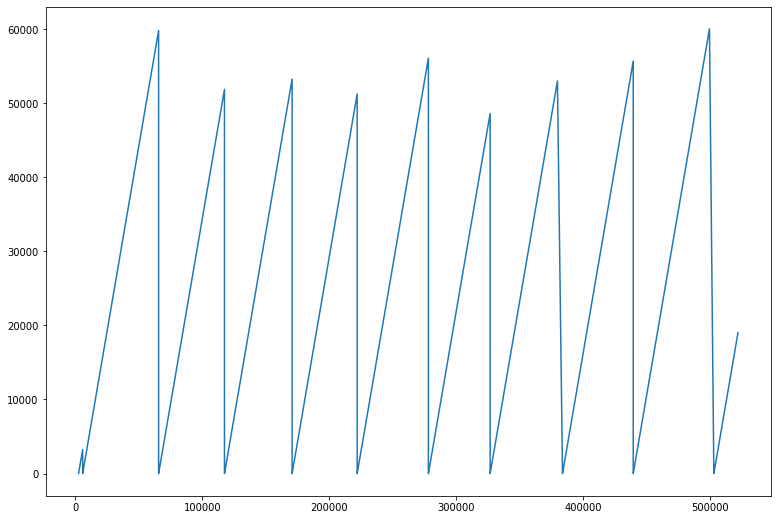

In [109]:
# for each of the 31 people there are 40 recordings of music clips, 10 in each run. this is one run and the times of each trial visualized. we need to trim them a bit, not sure how long yet but there really are only 12 seconds of audio per trial. 
responses.trial_itime.plot(figsize=(13,9)) 

<AxesSubplot:>

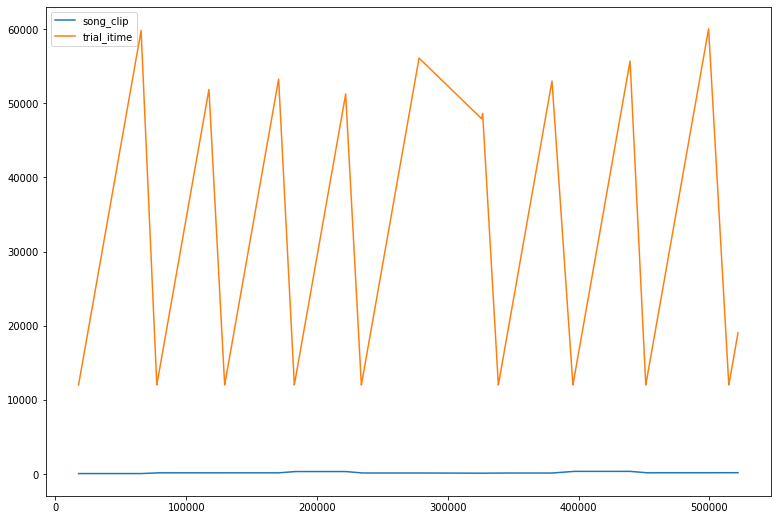

In [110]:
responses[responses.trial_itime > 12000][['song_clip','trial_itime']].plot(figsize=(13,9))

<AxesSubplot:>

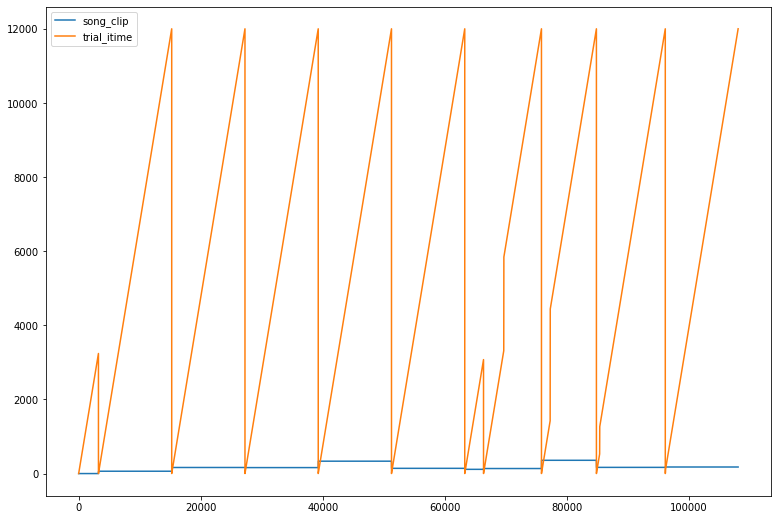

In [111]:
# remove itimes after 12s to get only the time when music is playing
responses[responses.trial_itime <=12000].reset_index(drop=True)[['song_clip','trial_itime']].plot(figsize=(13,9))
# responses = responses[responses.trial_itime <=12000].reset_index(drop=True)
# responses

<AxesSubplot:>

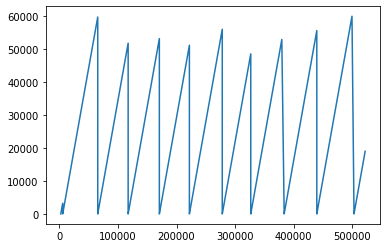

In [112]:
responses.trial_itime.plot() 

<AxesSubplot:>

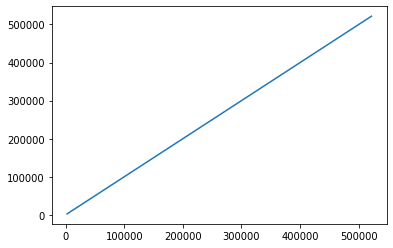

In [113]:
responses.time.plot()

In [114]:
responses.groupby('song_clip').max()

,time,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,...,P3,Pz,P4,T6,O1,O2,onset_time,trial_type,trial_name,trial_itime
song_clip,,,,,,,,,,,,,,,,,,,,,
-1,5688,24.262921,63.713294,168.376805,80.019042,31.122878,7.982375,8.008008,65.774957,50.860991,...,35.845222,27.441461,29.676930,32.970407,184.565175,115.542893,3713,786,artifact:EOG,3239
62,65481,83.291176,173.534657,147.946023,55.966035,31.021914,48.109441,61.256214,95.500499,60.235920,...,72.279639,65.744531,78.143535,69.716763,187.089309,154.104515,62482,788,n/a,59792
113,326512,121.104202,103.286568,167.518569,91.700699,32.781967,83.195705,195.401221,78.353344,140.662939,...,30.528394,-1.623327,1.460978,-35.804055,110.350301,107.536302,325802,788,n/a,48607
135,379502,251.765054,269.870156,417.837357,301.798108,30.170540,245.555111,295.877171,287.502948,572.318000,...,78.169495,25.811177,58.744280,35.809353,151.724726,149.834935,379403,788,n/a,52989
140,277904,241.344633,273.241622,196.674748,81.312214,49.823096,53.605909,122.599160,124.469340,258.419529,...,49.082891,14.981427,31.222059,-17.370900,137.060711,114.676340,277153,788,n/a,56080
160,170592,172.145547,204.651632,105.844787,37.710752,45.323365,8.324124,-11.520550,66.031950,17.121457,...,25.755580,-23.765874,-21.804254,-33.125050,83.599826,73.370633,169721,788,n/a,53247
163,117344,221.814142,232.784029,145.657394,37.516776,53.818006,-33.896157,-29.556641,13.005694,16.474910,...,16.652415,-14.057484,-26.874800,-43.041368,63.580374,68.406004,116705,788,n/a,51862
166,499201,175.515025,159.772443,125.917970,87.907394,18.259486,86.655916,118.045869,103.238849,227.691541,...,54.827677,1.214576,20.223262,-26.927351,127.204570,110.271361,497700,788,n/a,60032
176,521668,-130.046671,16.899658,215.055299,-18.887094,7.611850,82.483727,226.161230,87.062557,123.801679,...,17.508330,-22.924854,2.217776,-37.323491,102.537506,104.855403,505668,788,artifact:EOG,19027


In [115]:
[1:3]

SyntaxError: invalid syntax (<ipython-input-115-6e28223d7386>, line 1)

In [70]:
responses[responses.time > 77480]

,time,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,...,Pz,P4,T6,O1,O2,onset_time,trial_type,song_clip,trial_name,trial_itime
27241,77481,-75.136667,-59.372854,-48.113188,-11.796198,-0.912807,-115.189776,-146.803880,-48.801162,-52.416353,...,-70.418763,-78.046958,-115.854331,-32.056249,1.970251,65482,788,163,Music played,11999
27242,77482,-74.450291,-60.478253,-47.970149,-9.856440,-1.638659,-115.118579,-147.461577,-48.729775,-51.174302,...,-71.678136,-78.601943,-118.053515,-42.673637,-1.369589,65482,788,163,Music played,12000
27243,117345,7.290738,62.497356,35.111849,-26.279729,14.952225,-78.238131,-85.815079,-33.909836,0.039010,...,-57.898347,-45.113632,-65.153157,32.769916,25.150552,117345,257,160,artifact:EOG,0
27244,117346,-0.196990,55.312264,29.485637,-25.051216,15.132323,-79.519691,-88.698830,-36.351271,-0.573508,...,-58.955013,-45.883043,-64.793291,30.633083,26.838526,117345,257,160,artifact:EOG,1
27245,117347,5.668397,59.236429,32.680181,-28.693651,14.572927,-77.127446,-83.690210,-40.520271,0.209154,...,-59.808972,-46.400189,-67.672222,30.833411,27.831452,117345,257,160,artifact:EOG,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108025,514637,-169.544436,-51.690333,-27.062570,-81.929248,-11.025606,-59.328002,-41.901119,-10.694787,-28.715308,...,-54.167669,-53.665449,-110.016499,13.792170,23.128595,505668,788,176,Music played,11996
108026,514638,-166.611742,-54.122210,-25.393778,-79.881725,-12.040706,-58.601785,-41.142237,-11.637095,-28.613222,...,-53.611302,-54.201515,-109.336751,9.932515,20.393536,505668,788,176,Music played,11997
108027,514639,-166.050163,-57.880566,-23.295868,-78.373024,-11.353057,-60.210854,-43.165922,-9.152828,-29.702143,...,-53.559547,-52.750985,-111.575920,11.588561,21.467701,505668,788,176,Music played,11998
108028,514640,-166.050163,-61.694191,-25.560657,-77.618674,-12.188059,-63.172682,-46.201449,-8.895835,-30.535848,...,-53.684621,-56.932294,-112.215682,10.359882,20.429642,505668,788,176,Music played,11999


In [37]:
set1 = pd.read_csv('set1\set1\mean_ratings_set1.csv').drop(['Unnamed: 10', 'Unnamed: 11'],axis=1)
set1

,Number,valence,energy,tension,anger,fear,happy,sad,tender,TARGET
0,1,4.83,6.83,3.17,1.00,1.00,7.33,1.00,1.00,HAPPY
1,2,4.83,6.17,3.83,1.00,1.00,7.17,1.17,1.83,HAPPY
2,3,5.60,6.20,3.00,1.00,1.00,7.17,1.00,1.00,HAPPY
3,4,4.67,6.33,3.83,1.00,1.00,7.17,1.00,1.00,HAPPY
4,5,6.50,5.00,3.17,1.17,1.00,7.17,1.00,2.83,HAPPY
...,...,...,...,...,...,...,...,...,...,...
355,356,4.80,2.40,3.60,1.00,1.00,1.33,6.67,4.50,LOW TENSION
356,357,5.00,2.83,3.67,1.00,2.40,1.00,2.60,4.20,LOW TENSION
357,358,4.20,2.20,4.00,1.00,1.83,1.67,5.50,4.33,LOW TENSION
358,359,4.60,4.20,4.20,1.00,1.33,3.33,2.67,1.00,LOW TENSION


In [38]:
{x:'target_'+str.lower(x) for x in set1.columns} #for renaming target values

{'Number': 'target_number',
 'valence': 'target_valence',
 'energy': 'target_energy',
 'tension': 'target_tension',
 'anger': 'target_anger',
 'fear': 'target_fear',
 'happy': 'target_happy',
 'sad': 'target_sad',
 'tender': 'target_tender',
 'TARGET': 'target_target'}

In [39]:
set2 = pd.read_csv('set2\set2\mean_ratings_set2.csv')
set2

,Number,valence,energy,tension,anger,fear,happy,sad,tender,beauty,liking,TARGET,Soundtrack,Index in Set 1
0,1,2.56,7.73,8.38,6.39,4.40,1.21,1.75,1.01,4.71,4.97,ANGER_HIGH,Lethal weapon 3,227
1,2,2.50,8.21,8.56,5.76,5.93,1.09,1.60,1.10,4.57,4.79,ANGER_HIGH,The Rainmaker,124
2,3,2.92,8.21,8.17,6.31,4.06,1.31,1.55,1.01,4.45,5.06,ANGER_HIGH,The Alien Trilogy,125
3,4,2.88,6.75,7.98,5.42,4.51,1.19,2.10,1.06,4.00,4.35,ANGER_HIGH,Cape Fear,168
4,5,3.08,6.83,7.50,6.13,4.24,1.07,2.96,1.07,5.08,5.35,ANGER_HIGH,The Fifth Element,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,106,7.37,3.73,2.21,1.00,1.00,3.13,2.45,6.57,6.30,5.93,TENSION NEG HIGH,Lethal weapon 3,333
106,107,7.09,4.21,2.75,1.00,1.09,4.26,2.43,5.89,6.34,5.36,TENSION NEG HIGH,The Godfarher,191
107,108,5.87,2.97,3.54,1.02,1.45,1.17,5.13,4.09,6.38,5.94,TENSION NEG HIGH,Gladiator,45
108,109,5.37,2.28,3.22,1.13,1.45,1.02,7.00,3.47,6.72,6.08,TENSION NEG HIGH,Pride & Prejudice,278


In [40]:
set2['TARGET']

0            ANGER_HIGH
1            ANGER_HIGH
2            ANGER_HIGH
3            ANGER_HIGH
4            ANGER_HIGH
             ...       
105    TENSION NEG HIGH
106    TENSION NEG HIGH
107    TENSION NEG HIGH
108    TENSION NEG HIGH
109    TENSION NEG HIGH
Name: TARGET, Length: 110, dtype: object

In [41]:
set1[:1]

,Number,valence,energy,tension,anger,fear,happy,sad,tender,TARGET
0,1,4.83,6.83,3.17,1.0,1.0,7.33,1.0,1.0,HAPPY


In [42]:
set2['Index in Set 1'].sort_values().unique()

array([  1,   3,   4,  10,  11,  16,  18,  20,  21,  22,  29,  30,  32,
        36,  37,  39,  40,  45,  54,  58,  62,  79,  98, 104, 113, 114,
       115, 117, 124, 125, 156, 157, 160, 162, 163, 168, 170, 173, 177,
       178, 180, 187, 188, 189, 190, 191, 192, 204, 210, 215, 218, 219,
       227, 230, 234, 237, 239, 240, 246, 250, 253, 260, 261, 262, 263,
       265, 266, 269, 270, 273, 274, 276, 278, 280, 283, 288, 292, 293,
       294, 295, 296, 297, 299, 306, 309, 313, 316, 320, 321, 325, 329,
       331, 333, 334, 335, 340, 343, 346, 349, 353, 357, 360], dtype=int64)

In [43]:
record = get_recording(1,2)
record

Extracting EDF parameters from c:\Users\Staro\Desktop\UCSD\WI2021\cogs189\project\sub-01\eeg\sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


,time,FP1,FP2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
0,0,247.085224,226.427986,243.400921,91.204983,55.539856,30.993496,63.836413,-68.204146,-4.810091,-104.638740,-25.194368,17.563380,-16.669192,-54.736701,-80.506690,-107.095388,-113.935044,-22.240173,-24.044401
1,1,223.124495,217.253177,230.288985,87.282360,54.399233,29.484103,62.622202,-57.124885,-3.891314,-104.026181,-26.506049,17.346538,-26.118804,-53.851772,-79.859751,-106.698069,-119.452995,-21.425506,-25.461576
2,2,179.695673,170.218461,222.421823,85.062414,47.222584,15.159111,39.324530,-38.992590,3.748147,-98.604148,-26.024546,20.515767,-43.779133,-48.048959,-73.122966,-101.665362,-113.615163,-19.448936,-17.671623
3,3,179.258889,176.187614,217.534647,75.923996,47.121620,16.625785,38.768017,-34.866422,0.600485,-98.619684,-24.048723,24.352201,-47.422943,-48.302832,-75.577019,-102.460000,-116.374138,-19.422225,-20.596241
4,4,191.114458,167.068075,230.479704,71.527210,48.106704,13.706676,35.783082,-32.053774,2.080737,-99.667248,-25.194368,16.062166,-46.256924,-47.164029,-75.827168,-101.791495,-116.294168,-20.797811,-21.760672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573995,573995,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000
573996,573996,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000
573997,573997,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000
573998,573998,3285.730000,2285.620000,623.957000,930.323000,90.227900,416.800000,742.555000,442.170000,572.318000,27.130200,545.370000,608.391000,238.276000,267.392000,98.941100,214.960000,580.767000,429.927000,370.797000


In [44]:
events = get_events(1,2)
events

,onset,trial_type,trial_name,trial_desc,trial_desc_cleaned,song_clip
0,2.449,263,artifact:50/60 Hz mains interference,artifact:50/60 Hz mains interference,artifact:50/60 Hz mains interference,-1
1,2.689,786,Cross on screen,Fixation cross displayed on screen,Fixation cross displayed on screen,-1
2,2.817,257,artifact:EOG,"artifact:EOG (blinks, fast, large amplitude)","blinks, fast, large amplitude",-1
3,3.713,257,artifact:EOG,"artifact:EOG (blinks, fast, large amplitude)","blinks, fast, large amplitude",-1
4,5.689,788,Music played,Start of music play,Start of music play,62
...,...,...,...,...,...,...
710,563.203,807,Question 08,Question 08 presented to user (The music made ...,tender,176
711,563.303,32768,not used,not used,not used,176
712,572.623,805,Question 06,Question 06 presented to user (The music made ...,happy,176
713,572.623,841,Response 09,Response 09 - The user selected 09 as their re...,Response 09,176
